In [16]:
import deepchem as dc
import tensorflow as tf
import numpy as np
import rdkit
from rdkit import *

## Chapter 4

In [17]:
# Ways to represent small molecules

smiles = ['C1CCCC1', 'O1CCOCC1']
mols = [rdkit.Chem.MolFromSmiles(smile) for smile in smiles]

# ECFP4 fingerprints:
feat = dc.feat.CircularFingerprint(size=1024)
arr = feat.featurize(mols)
np.shape(arr)

(2, 1024)

In [18]:
# Molecular Descriptors (like QSAR):
feat = dc.feat.RDKitDescriptors()
arr = feat.featurize(mols)
np.shape(arr)

(2, 111)

In [19]:
# Also graph convolutional networks:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


In [20]:
model = dc.models.GraphConvModel(n_tasks=1, mode='regression',dropout=0.2)
model.fit(train_dataset, nb_epoch=100)

/home/cbilodeau/anaconda2/envs/deepchem2/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.009898860938847065

In [21]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print(model.evaluate(train_dataset,[metric],transformers))
print(model.evaluate(test_dataset,[metric],transformers))

computed_metrics: [0.9174988354079998]
{'pearson_r2_score': 0.9174988354079998}
computed_metrics: [0.7702977479173475]
{'pearson_r2_score': 0.7702977479173475}


In [22]:
# We can now use this model to predict the solubilities of new molecules:
smiles = ['COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C',
         'CCOC(=O)CC', 'CSc1nc(NC(C)C)nc(NC(C)C)n1', 'CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1',
         'Cc1cc2ccccc2cc1C']

In [23]:
mols = [Chem.MolFromSmiles(s) for s in smiles]
featurizer = dc.feat.ConvMolFeaturizer()
x = featurizer.featurize(mols)

In [24]:
predicted_solubility = model.predict_on_batch(x)

In [25]:
print(predicted_solubility)

[[0.3434617 ]
 [1.5717566 ]
 [0.5191531 ]
 [0.63904214]
 [0.1227548 ]]


### SMARTS Strings

In [26]:
smiles_list = ['CCCCC','CCOCC','CCNCC','CCSCC']
mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]

In [27]:
# Query smiles string matching smarts pattern 'CCC':
query = Chem.MolFromSmarts('C[S,O]C')
match_list = [mol.GetSubstructMatch(query) for mol in mol_list]

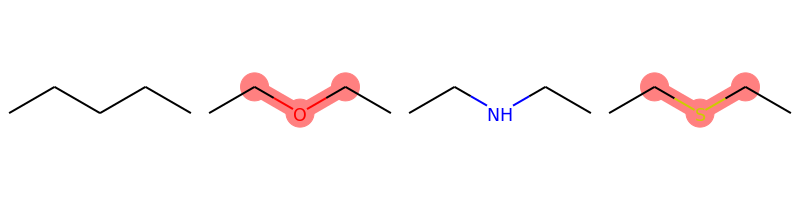

In [28]:
from rdkit.Chem.Draw import MolsToGridImage

MolsToGridImage(mols=mol_list,molsPerRow=4,highlightAtomLists=match_list)

## Chapter 5

In [37]:
grid_featurizer = dc.feat.RdkitGridFeaturizer(voxel_width=2.0,
                                             feature_types=['hbond','salt_bridge','pi_stack','cation_pi','ecfp','splif'],
                                             sanitize=True, flatten=True)

# This featurizer goes to each spatial voxel and counts biophysical fatures and computes a local fingerprint vector.

## Aside: Directions to deal with load_pdbbind_grid bug
The method load_pdbbind doesn't appear in deepchem version 2.1.1, so you can use load_pdbbind_grid. Ther is a bug, however that I observed. To fix this, I obtained the newest version of pdbbind_datasets.py at deepchem/molnet/load_function/pdbbind_datasets.py. The version being called by my version of deepchem is located on my computer at deepchem/molnet/load_function/pdbbind_datasets.py. I replaced the function "load_pdbbind_grid" in my copy (lines 48-127) with the function from the github page (lines 54-138). This got rid of my error.

Note: You will need to restart your kernel and reload deepchem for any changes to take effect.

In [38]:
# Load PDBBind dataset:
tasks, datasets, transformers = dc.molnet.load_pdbbind_grid(split='random',featurizer='grid',subset='core')
train_dataset, valid_dataset, test_dataset = datasets

Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.006 s
Loading dataset from disk.
TIMING: dataset construction took 0.006 s
Loading dataset from disk.


In [54]:
# Random Forest Model:
from sklearn.ensemble import RandomForestRegressor
sklearn_model = RandomForestRegressor(n_estimators=100)
model = dc.models.SklearnModel(sklearn_model)
model.fit(train_dataset)

In [56]:
# MultiLayer Perceptron:
n_features = train_dataset.X.shape[1]
model = dc.models.MultitaskRegressor(
    n_tasks=len(tasks),
    n_features=n_features,
    layer_sizes= [2000,1000],
    dropouts=0.5,
    learning_rate=0.0003)
model.fit(train_dataset,nb_epoch=250)

107.07924664306641

In [57]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Evaluating Model")
train_scores = model.evaluate(train_dataset,[metric],transformers)
test_scores = model.evaluate(test_dataset,[metric],transformers)
print('Train_scores')
print(train_scores)
print('Test scores')
print(test_scores)

Evaluating Model
computed_metrics: [0.986143342076055]
computed_metrics: [0.015461017703871843]
Train_scores
{'pearson_r2_score': 0.986143342076055}
Test scores
{'pearson_r2_score': 0.015461017703871843}
